# Fitting a power spectrum and MCMC sampling

This notebook shows how to fit a power spectrum in nDspec, and how to retrieve the posterior distribution of model parameters through Bayesian sampling. For typical fits, nDspec makes use of classes and functions from the [lmfit library](https://lmfit.github.io/lmfit-py/). For Bayesian inference and parameter posterior estimation, nDspec utilizes the [emcee package](https://emcee.readthedocs.io/en/stable/). Finally, parts of nDspec interface with [Stingray](https://docs.stingray.science/en/stable/) for loading in data.

In this notebook, we will use a NICER observation of the black hole X-ray binary MAXI J1820+070 as an example. This observation is identical to that used in the [spectral timing exploration](https://docs.stingray.science/en/stable/notebooks/Spectral%20Timing/Spectral%20Timing%20Exploration.html) notebook in the Stingray documentation.

In [1]:
import os
import sys
import numpy as np
from stingray import AveragedPowerspectrum, EventList
from stingray.fourier import poisson_level, get_average_ctrate

sys.path.append('/home/matteo/Software/nDspec/src/')

## Setting up a fit and loading data 

Setting up a fit for a power spectrum requires simply instatiating a `FitPowerSpectrum` object. The simplest method to assign the data to be fit is to pass three arrays to the object using the `set_data` method. The first array should contain the data itself, the second the error bars on the data, and the third the Fourier frequencies over which the power spectrum is defined. These will be stored in arrays called `data`, `data_err` and `freqs`, respectively.

In this example, we will define an array of logarithmically-spaced frequencies from 0.1 to 10 Hz, and compute a power spectrum made of a single Lorentzian for our data. nDspec comes with a small library of models, including a Lorentzian, but for clarity we will redefine that same function here to generate our fake data. After loading the data, we can visualize it using the `plot_data` method.

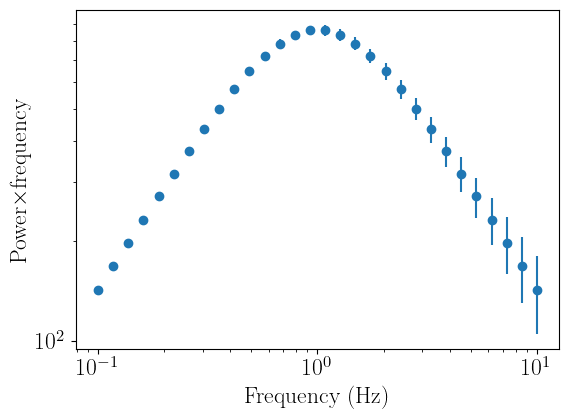

In [2]:
import ndspec.FitPowerSpectrum as fitpsd 
import ndspec.models as models

def lorentz(freq,peak_f,q,rms):
    par_array = np.array([peak_f,q,rms])
    model = models.lorentz(freq,par_array)
    return model

freq_array = np.logspace(-1,1,30)
psd_array = lorentz(freq_array,1,1e-1,50)
psd_err = np.sqrt(psd_array)

load_arrays = fitpsd.FitPowerSpectrum()

load_arrays.set_data(psd_array,psd_err,freq_array)
load_arrays.plot_data()

If instead we do not have our data already conveniently stored in arrays, we can calculate our power spectrum with Stingray, and then pass a Stingray `AveragedPowerspectrum` object to our `FitPowerSpectrum` instance. Let us first calculate the power spectrum from a NICER event file using, and then remove the Poisson noise, using Stingray:

In [3]:
obsid = str(106)
path =  "/home/matteo/Data/J1820/EventFiles/"
fname = path + "ni1200120" + obsid+ "_0mpu7_cl.evt"
events = EventList.read(fname, "hea", additional_columns=["DET_ID"])

#fill events -- see the Stingray docs 
ev_filled = events.fill_bad_time_intervals(max_length=1, buffer_size=4)
lc_filled = ev_filled.to_lc(dt=1)
events = ev_filled

segment_size = 256
dt = 0.001
norm = "frac"

psd = AveragedPowerspectrum.from_events(
    events, segment_size=segment_size, dt=dt, norm=norm, use_common_mean=True
)

ctrate = get_average_ctrate(events.time, events.gti, segment_size)
noise = poisson_level(norm, meanrate=ctrate)

psd_reb = psd.rebin_log(0.05)

#only look at high frequencies and remove the noise
psd_reb.power = psd_reb.power-noise

14it [00:00, 30.99it/s]


We can then simply pass the `AveragedPowerspectrum` object `psd_red` reb to our fitter instance. The Fourier frequency and error arrays are stored automatically.

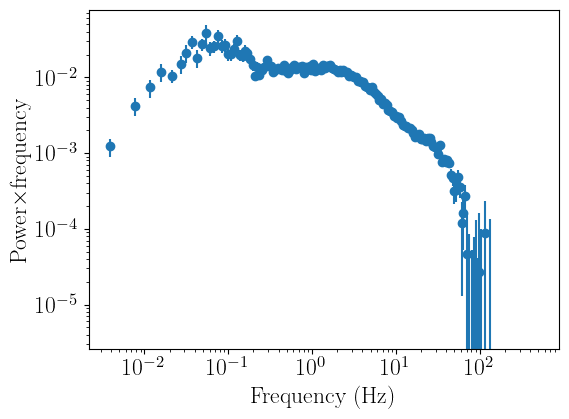

In [4]:
psd_fit = fitpsd.FitPowerSpectrum()

psd_fit.set_data(psd_reb)
psd_fit.plot_data()

As one would expect from the PSD of a black hole XRB, the signal drops noticeably above ~tens of Hertz. Therefore, let us ignore all frequencies above 20 Hertz. We can do this with the `ignore_frequencies` methods, passing the lower and upper bound of the range we want to ignore:

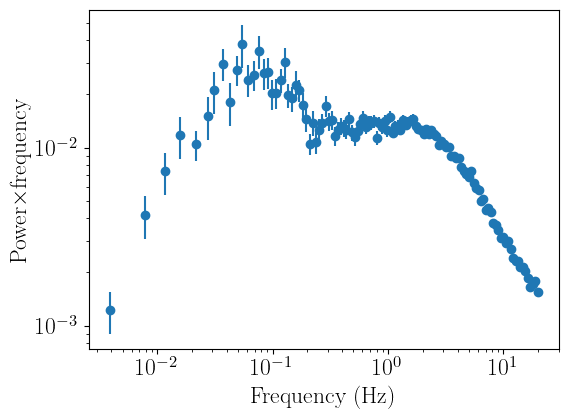

In [5]:
psd_fit.ignore_frequencies(20.0,np.max(psd_fit.freqs))
psd_fit.plot_data()

## Fitting the data

Let us now fit this powerspectrum with a standard model, made of multiple Lorentzians. For this, we will instatiate a lmfit `Model` object, which will contain three instances of the Lorentzian function we defined at the start. For the sake of distinguishing between the three components, we can assign a prefix to each. 

We then want to store the parameters for our model in an lmfit `Parameters` object. Setting up the parameters requires passing a dictionary containing, in order, the name of each parameter, its starting value, whether it's variable or not, and its minimum and maximum allowed values. It is also possible to pass expressions to tie parameters to each other (even in non-obvious forms); we refer users interested in this feature to the lmfit documentation [here](https://lmfit.github.io/lmfit-py/parameters.html#the-parameters-class).

Once our model and parameters are defined, we can pass them to our fitter instance with the `set_model` and `set_parameters` methods, and then compare this model instance to the data by calling `plot_model`.

 - Adding parameter "l1_peak_f"
 - Adding parameter "l1_q"
 - Adding parameter "l1_rms"
 - Adding parameter "l2_peak_f"
 - Adding parameter "l2_q"
 - Adding parameter "l2_rms"
 - Adding parameter "l3_peak_f"
 - Adding parameter "l3_q"
 - Adding parameter "l3_rms"


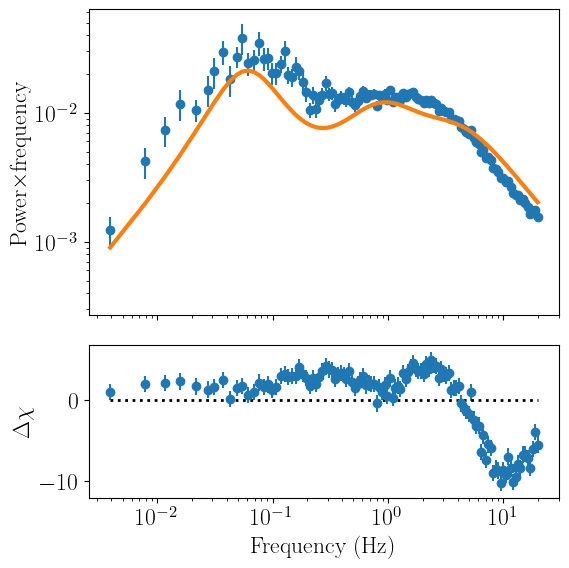

In [6]:
from lmfit import Model as LM_Model
from lmfit import Parameters as LM_Parameters

Lorentz_model = LM_Model(lorentz, prefix="l1_") + \
                LM_Model(lorentz, prefix="l2_") + \
                LM_Model(lorentz, prefix="l3_")

Lorentz_model_parameters = LM_Parameters()
Lorentz_model_parameters.add_many(('l1_peak_f', 0.06, True, 1e-3, 0.3),
                                  ('l1_q', 0.5, True, 0, 2),
                                  ('l1_rms', 0.20, True),
                                  ('l2_peak_f', 0.9, True, 0.3, 1.25),
                                  ('l2_q', 0.3, True, 0, 2),
                                  ('l2_rms', 0.15, True),
                                  ('l3_peak_f', 4.0, True, 1.25, 10),
                                  ('l3_q', 0.2, True, 0, 2),
                                  ('l3_rms', 0.12, True),
                                 )

psd_fit.set_model(Lorentz_model)
psd_fit.set_params(Lorentz_model_parameters)
psd_fit.plot_model()

The model is somewhat close to the data, but it's clearly not a great fit. We can check just how badly (or well) our model and parameters fit the data with the `print_fit_stat` method. Currently, the only fitting statistic that nDspec supports is chi squared.

In [7]:
psd_fit.print_fit_stat()

Goodness of fit metrics:
Chi squared             2046.8620374676805
Reduced chi squared     19.493924166358862
Data bins:              114
Free parameters:        9
Degrees of freedom:     105


Even though the model does not fit the data well, it is close enough that we can actually run a fit and expect to get a reasonable result. For this, we can use the `fit_data` method. 

By default, this method uses the Levenberg-Marquardt algorithm to find a best-fit by optimizing the chi-squared residuals, ie, (data-model)^2/error^2. Users can also specify different fitting algorithms by passing the argument `algorithm` to the method. The list of supported algorithms is listed [on the lmfit documetation page](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.minimize), although note that out of these, `emcee` is not supported as nDspec uses its own interface with the original Python package.

Once the fit completes, the result (including best-fit statistic, some simple model selection criteria, and best-fit parameter value) are reported on the terminal. Note that, even though formally this fit also returns parameter uncertainties, these are NOT reliable estimates and should not be reported in scientific publications as such. A much more robust method of estimating uncertainties is shown in the second of this notebook.

Finally, let us plot the model and data again:

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 205
    # data points      = 114
    # variables        = 9
    chi-square         = 110.280036
    reduced chi-square = 1.05028606
    Akaike info crit   = 14.2179894
    Bayesian info crit = 38.8437754
[[Variables]]
    l1_peak_f:  0.06387941 +/- 0.00378567 (5.93%) (init = 0.06)
    l1_q:       0.33420413 +/- 0.07297536 (21.84%) (init = 0.5)
    l1_rms:     0.24969327 +/- 0.00809322 (3.24%) (init = 0.2)
    l2_peak_f:  0.78487113 +/- 0.26730259 (34.06%) (init = 0.9)
    l2_q:       0.08555367 +/- 0.27720823 (324.02%) (init = 0.3)
    l2_rms:     0.16042662 +/- 0.04660825 (29.05%) (init = 0.15)
    l3_peak_f:  2.45164457 +/- 0.44942199 (18.33%) (init = 4)
    l3_q:       0.32985330 +/- 0.17324876 (52.52%) (init = 0.2)
    l3_rms:     0.12323796 +/- 0.05174367 (41.99%) (init = 0.12)


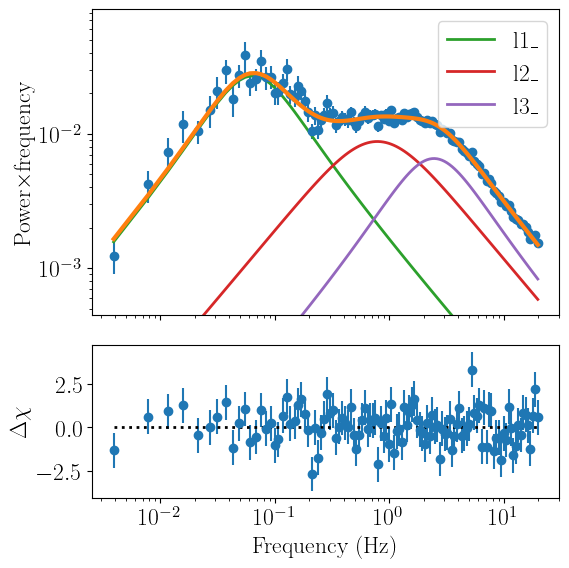

In [8]:
psd_fit.fit_data()
psd_fit.plot_model(plot_components=True)

## Parameter posterior distributions with Emcee

Now that we have a reasonable fit, we want to find out how well the parameters are constrained by the data - using Bayesian terminology, we want to sample their posterior distribution. nDspec offers a simple interface to the popular `emcee` package run a Markov Chain Monte Carlo (MCMC) sampler. `emcee` is a Python implementation of the [Goodman-Ware affine-invariant MCMC sampler](https://msp.org/camcos/2010/5-1/p04.xhtml). Essentially it sets up a series of "walkers" which then move around and explore the parameter space; each step of a walker to a new position may be accepted or rejected based on the change in fit likelihood. For more details, we refer users to the original `emcee` [publication paper](https://arxiv.org/abs/1202.3665). Additionally, users are strongly encouraged to read [Hogg and Foreman-Mackey 2017](https://arxiv.org/abs/1710.06068) for more details and good practices when using MCMC sampling.

To begin, we import a few nDspec utility fuctions required by the MCMC sampler, and then use a series of setters to specify the data and error (`set_emcee_data`), model (`set_emcee_model`), and initial parameters (`set_emcee_parameters`). We also save the latter in an array called ```theta```, which we will use to define the starting position of the walkers in our MCMC chain. Finally, we define the number of walkers that the chan will use, as well as its length.

Users should keep an important note in mind: in order to optimize parallel computing of the chain, the parameter names, values, the data and its error, the model, and the priors (see below) are all saved in global variables with the prefix `emcee_` - for example, parameter names are saved in the variable `emcee_names`. In their analysis users should never overwrite these variables with their own. This is easily done by simply not having any user-defined variable begin with the prefix `emcee_`.

In [9]:
import ndspec.EmceeUtils as ndmc 

ndmc.set_emcee_data(psd_fit.data,psd_fit.data_err)
ndmc.set_emcee_model(psd_fit.eval_model) 

theta = ndmc.set_emcee_parameters(psd_fit.model_params)

nwalkers = 32
ndim = len(theta)
steps = 200000
#pos is the initial positions of the walkers - we will set it to be within 1% of the best fitting values
pos = theta*(1+ 1e-2 * np.random.randn(nwalkers, len(theta)))

Next, we must define the priors for each of our parameters. Posterior sampling with algorithm like `emcee` is by nature based on a Bayesian framework, so users should always put thought in how they define the priors for each of the model free parameters.

The `EmceeUtils` module in nDspec comes with four different types of priors: uniform, log-uniform, normal, and log-normal. In this case, we will use only uniform priors for all our parameters. Once we have done so, we can create a dictionary called `my_priors` and save that by calling `set_emcee_priors`. Users can also create their own priors; in this case, they are encouraged to read the [nDspec API](https://ndspec.readthedocs.io/en/latest/api.html). 

Finally, we can double check the likelihood for our initial model. Note that `lmfit` maximizes the log of the chi-squared statistic: (data-model)^2/error^2. On the other hand `emceee` requires the negative log-likelihood: -0.5*(data-model)^2/error^2. As a result, if the chi squared of our fit from `lmfit` is 110, the log-likelihood in `emcee` should be -55, which is indeed the case here.

In [10]:
#define the priors - for each, pass a minum and maximum value, then group them in a dictionary.
l1_peak_prior = ndmc.priorUniform(0,0.3)
l1_q_prior = ndmc.priorUniform(1e-5,2)
l1_rms_prior = ndmc.priorUniform(1e-3,1)

l2_peak_prior = ndmc.priorUniform(1e-1,1.25)
l2_q_prior = ndmc.priorUniform(1e-5,1)
l2_rms_prior = ndmc.priorUniform(1e-3,1)

l3_peak_prior = ndmc.priorUniform(1.25,10)
l3_q_prior = ndmc.priorUniform(1e-5,1)
l3_rms_prior = ndmc.priorUniform(1e-3,1)

my_priors = {
    "l1_peak_f": l1_peak_prior,
    "l1_q": l1_q_prior,
    "l1_rms": l1_rms_prior,
    "l2_peak_f": l2_peak_prior,
    "l2_q": l2_q_prior,
    "l2_rms": l2_rms_prior,
    "l3_peak_f": l3_peak_prior,
    "l3_q": l3_q_prior,
    "l3_rms": l3_rms_prior,
}

ndmc.set_emcee_priors(my_priors)

likelihood = ndmc.chi_square_likelihood(theta)
print(likelihood)

-55.140018232906904


Having set up the model, data, its error, and the priors, we can finally run the emcee sampler. We will use `multiprocessing` to speed up the computation, and save the results of our sampler in an `EnsembleSampler` object called `parallel_sampler`. For more advanced settings, we refer the user to the [emcee documentation page](https://emcee.readthedocs.io/en/stable/).

In [11]:
import emcee
import time 
import corner
from multiprocessing import Pool

with Pool() as pool:
    parallel_sampler = emcee.EnsembleSampler(nwalkers, ndim, ndmc.chi_square_likelihood, pool=pool)   
    start = time.time()
    parallel_sampler.run_mcmc(pos, steps, progress=True);
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [06:41<00:00, 498.11it/s]

Multiprocessing took 401.6 seconds


nDspec comes with a `process_emcee` function to quickly visualize the output of an `emcee` chain. Given an `EnsembleSampler` object, we can use this function to print the autocorrelation length for each parameter, and then plot the trace plots of each parameter, the acceptance rate for each walker, and the corner plot with the one and two dimensional posterior distribution for each parameter. In this example, we will also pass the parameter names, and the best-fit values found with our least-chi squares fit above, to compare our initial least chi-squares fit to the posterior distribution.

As a rule of thumb, one should not trust the results of a chain if it did not run for several times the longest autocorrelation length of one of the model parameters. Indeed, `process_emcee` (through the `emcee` `get_autocorr_time` method) will throw an error should this occur. In this case, the chain should be re-run for longer, until the parameter space is sampled sufficiently for the chain to converge. Additionally, when plotting trace and corner plots, users should discard a burn-in period somewhat longer than the autocorrelation length, and thin the chain (meaning, keeping one sample every x steps) by a factor also on the order of (but smaller than) the autocorrelation length. 

In our particular case, we ran the chain long enough to be reasonably confident in its results - the autocorrelation length is much shorter than the number of steps, and the acceptance rate is reasonable. The corner plot shows that the posterior distributions for many parameters, particularly those associated with the second and third Lorentzian, are highly asymmetric - this demonstrates that the simple estimates given by a least-chi squares fit are not reliable at all.

Autocorrelation lengths:  [ 304.26235192  311.81432683  305.72123754 1157.94467689 1376.86826538
 1453.25061537 1243.68040006 1351.3971033  1374.82916004]


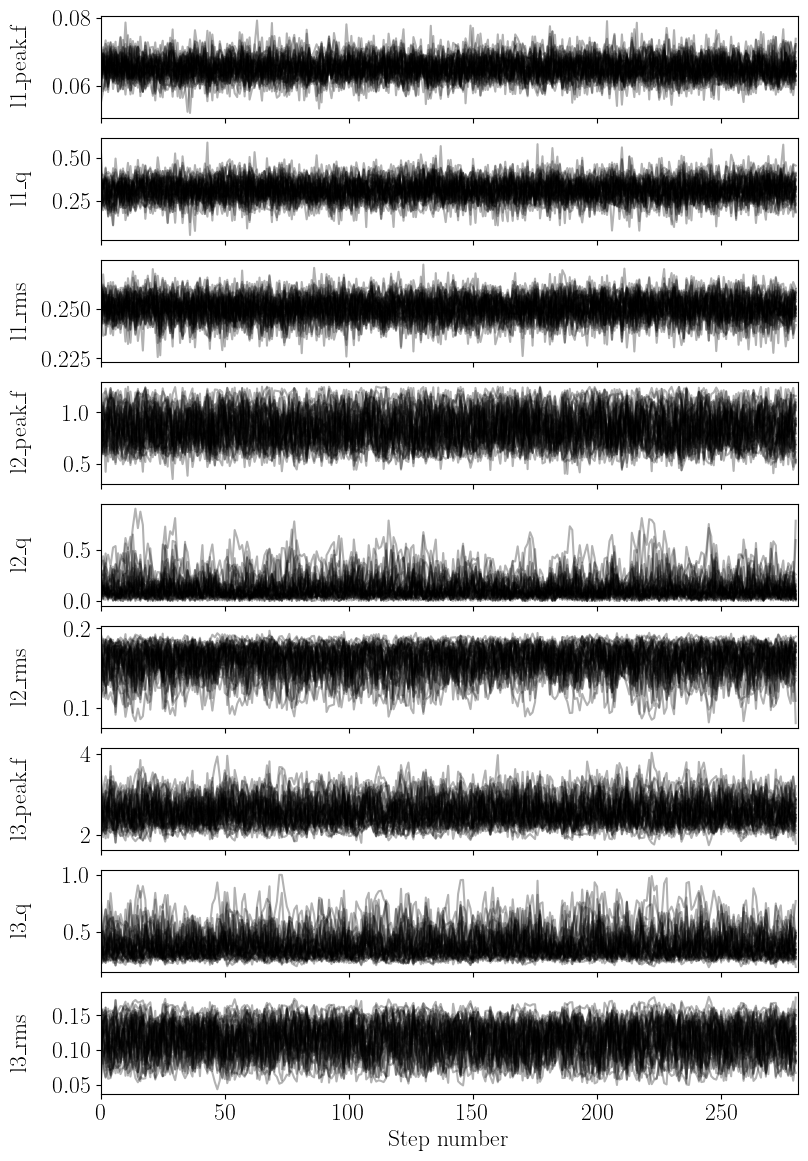

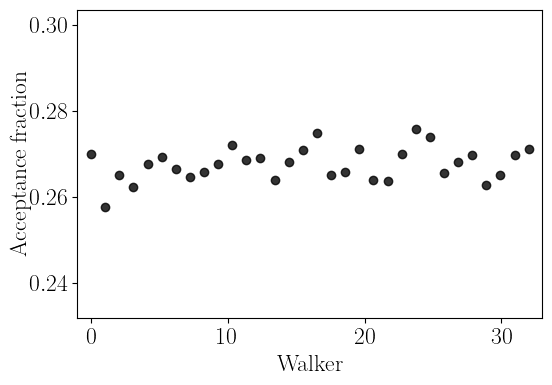

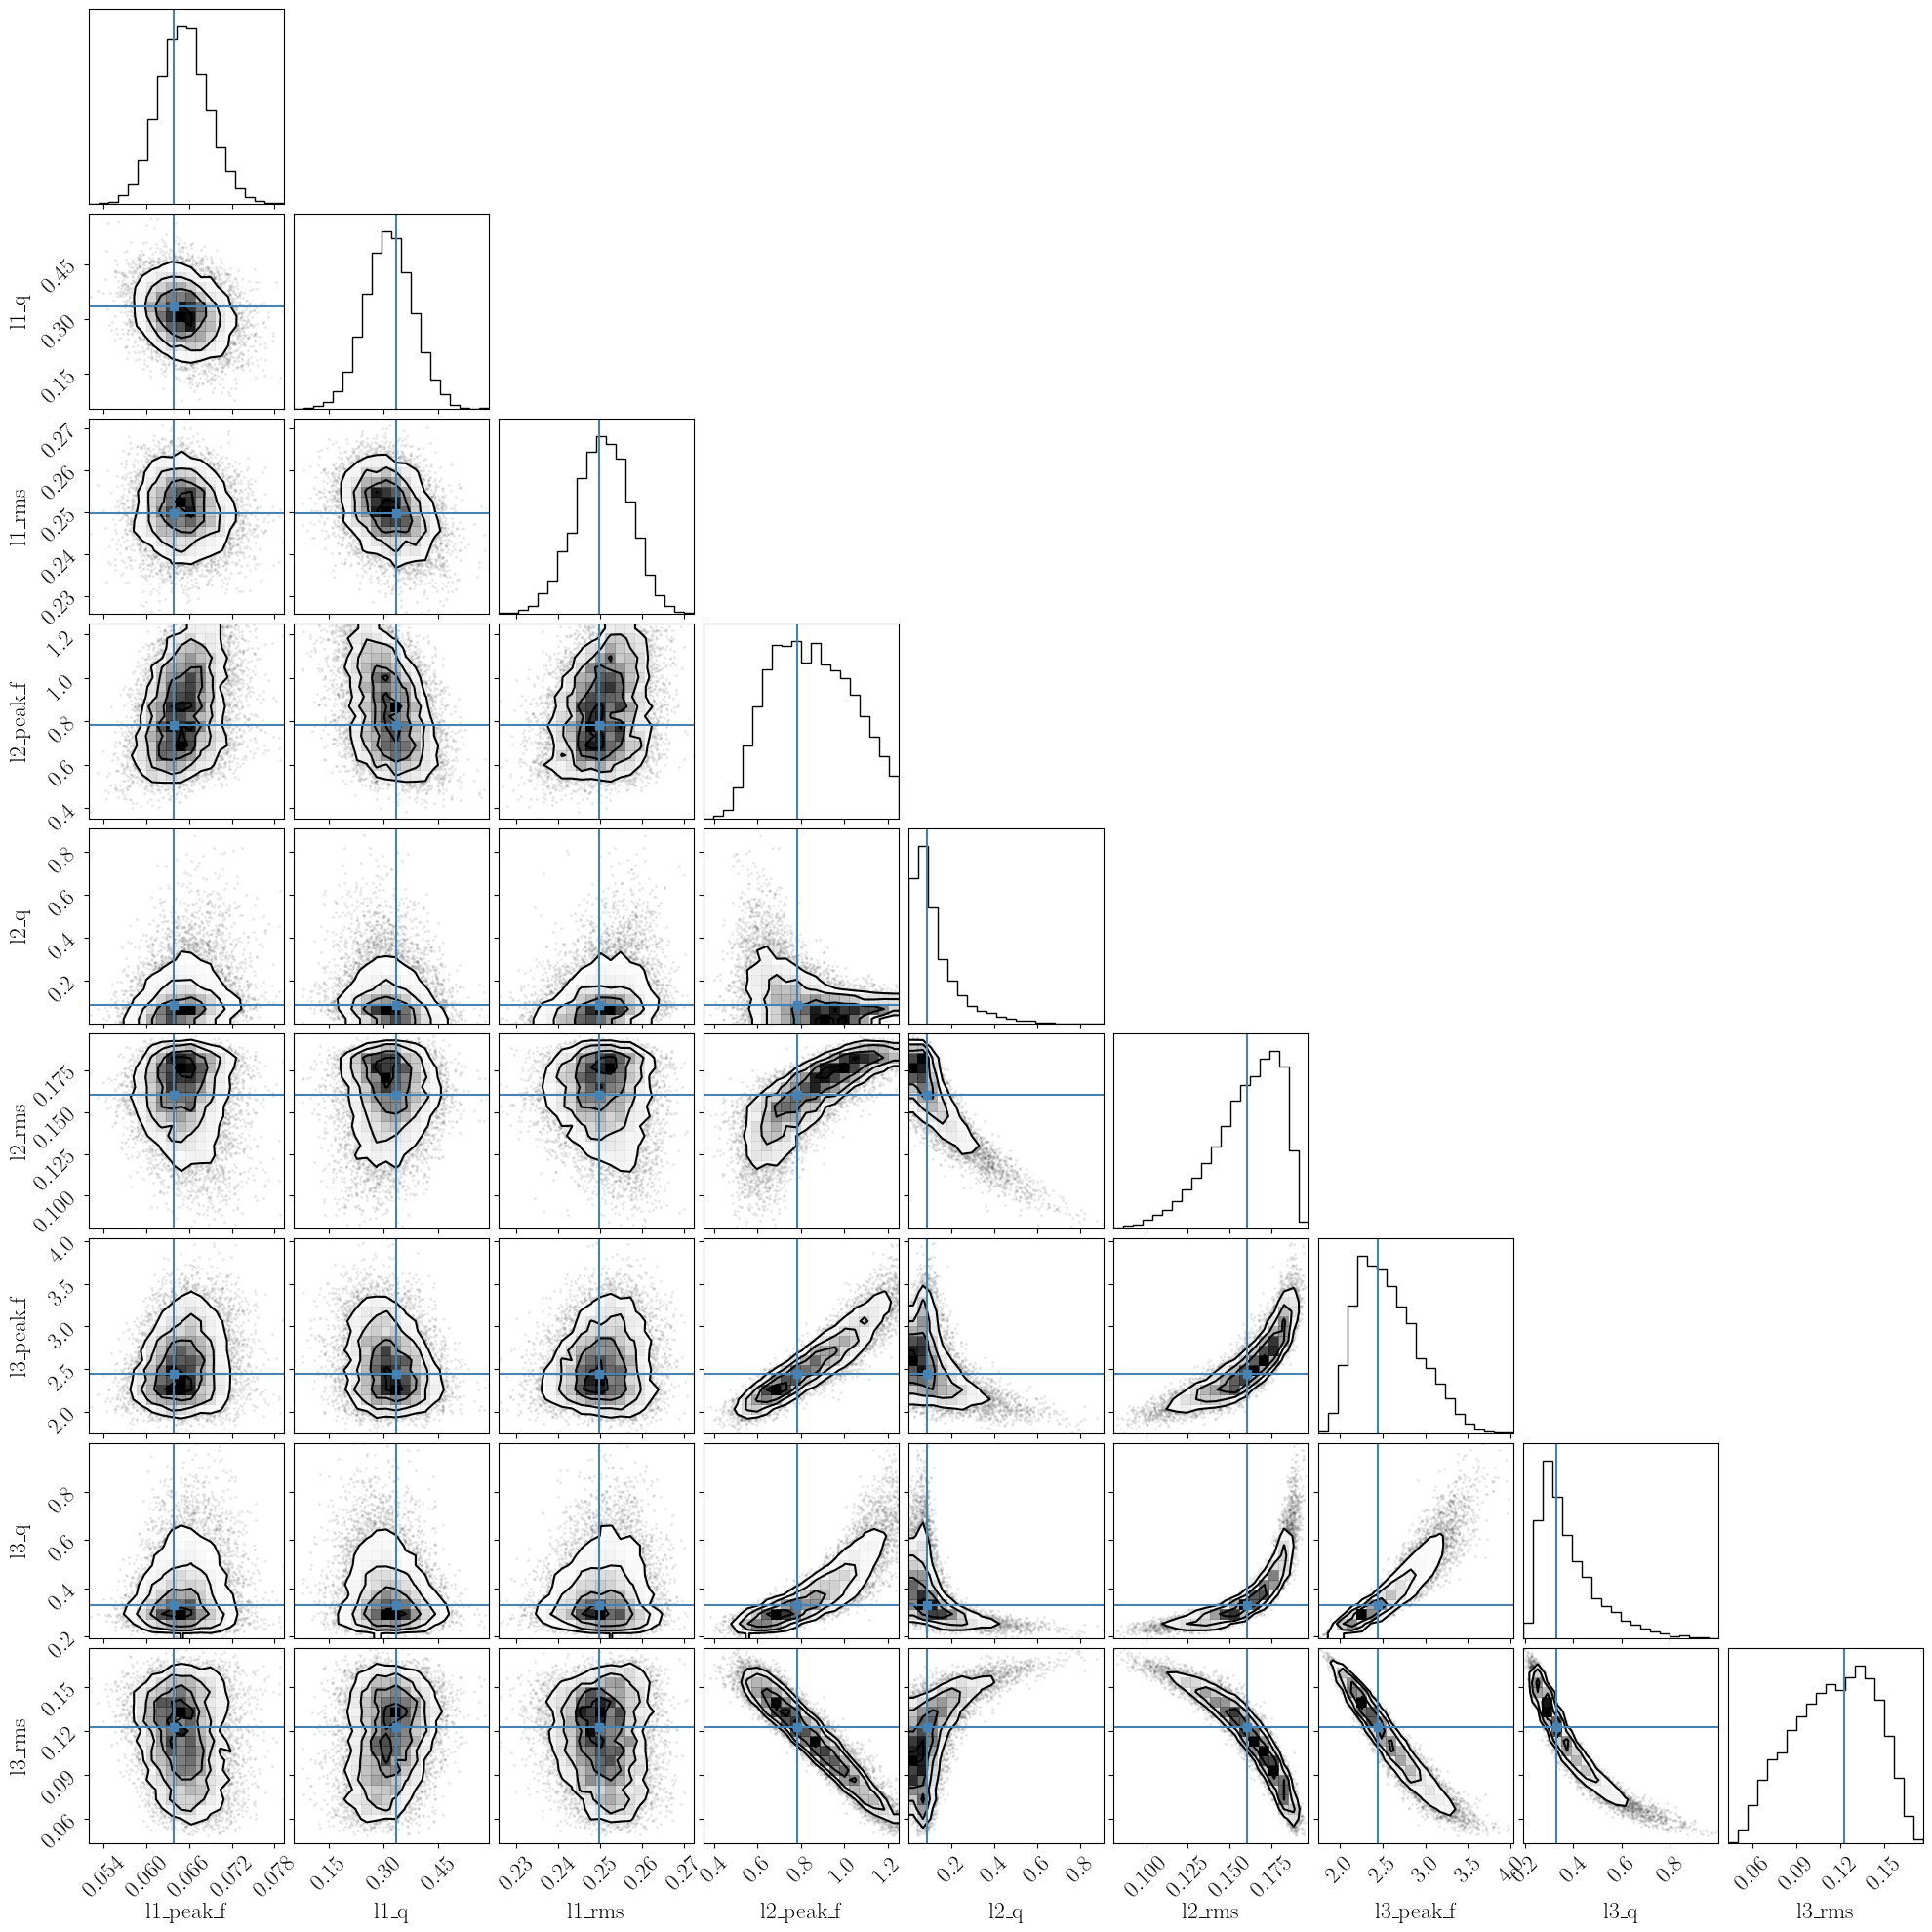

In [12]:
fit_names = []
fit_values = []
for key in psd_fit.model_params:
    fit_names = np.append(fit_names,psd_fit.model_params[key].name)
    fit_values = np.append(fit_values,psd_fit.model_params[key].value)

ndmc.process_emcee(parallel_sampler,labels=fit_names,values=fit_values,discard=3000,thin=700)

## Calculating parameter credible ranges

Now that we have both a best-fit (from minimizing a fit statistic) and posterior distributions for all the parameters (from MCMC sampling), how would one go about defining _a_ best fit? And how would one report best-fitting parameters and their range?

This is not as straightforward as one would think, and depends on whether one takes a frequentist or Bayesian approach. Given that we are using MCMC sampling and talking about priors, posteriors etc, we are taking the latter. In a Bayesian framework, a single-number answer (like a best-fit value) does not make sense. Instead, a probability distribution function (ie, a posterior) does. As a result, we should strive to a) report numbers that give a summary of what these distributions look like, b) explicitely make the distributions available in both plot and file form (e.g. by uploading the output of an `emcee` run to a public repository).

Having said that, a reasonable way to report a fit would be to report intervals related to percentiles in the posterior distribution of each parameter - for example, by reporting the 50th percentile as the "best-fit" value, the 16th and 84th percentiles as the "one-sigma" credible range, and the 5th and 95th percentile sas the "two-sigma" credible range. The advantage of reporting multiple percentile ranges is that it can give readers an idea of how skewed the posterior might be. 

It is also acceptable (and possibly more intuitive) to report the mean of the distribution rather than the median. However, in this case one should be careful, because for pathological distributions (e.g, very skewed ones) the mean might actually lie outside of the one-sigma credible range. 

Another important consideration to keep in mind is that if we collectively take the median of every posterior distribution, assign that to our model, and evaluate it against the data, we might actually find a bad fit - even though we're taking our "best fit values"! This seems counterintuitive, but one must remember that MCMC does NOT perform optimization, it performs sampling. The regions that end up with the most samples (ie, where our posterior peaks) are not necessarily the ones of highest probability, if our parameter space has significant curvate (e.g. because of model degeneracies). This is shown very well in the corner plot above - the best-fit values of $l2_{rms}$ and $l3{q}$ (shown by the blue lines) are slightly offset from the peaks of the distribution. 

To sum up, reporting error bars and best-fit values is a very complex statistical problem, and describing it in detail goes well beyond the scope of the nDspec documentation. The code below is an example of what would be good practice for reporting fitting results: use percentiles derived from the posterior distributions, compare the mean and median of the posterior, and possibly also report the result of an optimization algorithm.

In [13]:
flat_samples = parallel_sampler.get_chain(discard=3000, thin=700,flat=True)    

for i in range(ndim):
    #calculate the mean of the posterior
    mean = np.mean(flat_samples[:, i])

    #get the median and one sigma percentiles
    onesigma_percentile = np.percentile(flat_samples[:, i], [16, 50, 84])
    onesigma_interval = np.diff(onesigma_percentile)

    #also get the two sigma percentiles
    twosigma_percentile = np.percentile(flat_samples[:, i], [5, 50, 95])
    twosigma_interval = np.diff(twosigma_percentile)

    #make the printing more readable    
    print_space = len(fit_names[i])+2
    print(f"{fit_names[i]}; mean: {mean:.3f}; median: {onesigma_percentile[1]:.3f}; optimizer: {fit_values[i]:.3f}")
    print(" "*print_space + f"1-\u03C3 range from median: +{onesigma_interval[1]:.3f} -{onesigma_interval[0]:.3f}")
    print(" "*print_space + f"2-\u03C3 range: +{twosigma_interval[1]:.3f} -{twosigma_interval[0]:.3f}")

l1_peak_f; mean: 0.065; median: 0.065; optimizer: 0.064
           1-σ range from median: +0.004 -0.003
           2-σ range: +0.006 -0.006
l1_q; mean: 0.315; median: 0.315; optimizer: 0.334
      1-σ range from median: +0.066 -0.064
      2-σ range: +0.109 -0.108
l1_rms; mean: 0.251; median: 0.251; optimizer: 0.250
        1-σ range from median: +0.006 -0.007
        2-σ range: +0.010 -0.011
l2_peak_f; mean: 0.850; median: 0.842; optimizer: 0.785
           1-σ range from median: +0.211 -0.188
           2-σ range: +0.318 -0.272
l2_q; mean: 0.124; median: 0.089; optimizer: 0.086
      1-σ range from median: +0.122 -0.055
      2-σ range: +0.273 -0.077
l2_rms; mean: 0.160; median: 0.163; optimizer: 0.160
        1-σ range from median: +0.017 -0.025
        2-σ range: +0.023 -0.043
l3_peak_f; mean: 2.569; median: 2.519; optimizer: 2.452
           1-σ range from median: +0.433 -0.312
           2-σ range: +0.722 -0.456
l3_q; mean: 0.381; median: 0.345; optimizer: 0.330
      1-σ range f